This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray powered Cf/Radial and ODIM_H5

In this example, we read and write Cf/Radial (NetCDF) and ODIM_H5 (HDF5) data files from different sources using an xarray powered data structure.

In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
from wradlib.io.xarray import CfRadial, OdimH5

## Load ODIM_H5 Volume Data

In [2]:
fpath = 'hdf5/knmi_polar_volume.h5'
f = wrl.util.get_wradlib_data_file(fpath)
cf1 = OdimH5(f)

### Inspect root group

You can use the object dictionary using cf1['root'] or the `property` cf1.root.

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [3]:
cf1.root

<xarray.Dataset>
Dimensions:              (sweep: 14)
Dimensions without coordinates: sweep
Data variables:
    altitude             float32 50.0
    instrument_type      <U5 'radar'
    latitude             float32 52.95334
    longitude            float32 4.78997
    platform_type        <U5 'fixed'
    primary_axis         <U6 'axis_z'
    sweep_fixed_angle    (sweep) float32 0.3 0.4 0.8 1.1 ... 12.0 15.0 20.0 25.0
    sweep_group_name     (sweep) <U8 'sweep_1' 'sweep_2' ... 'sweep_14'
    time_coverage_end    <U20 '2011-06-10T11:43:54Z'
    time_coverage_start  <U20 '2011-06-10T11:40:02Z'
    volume_number        int64 0
Attributes:
    Conventions:      ODIM_H5/V2_0
    version:          H5rad 2.0
    title:            None
    institution:      RAD:NL51;PLC:nldhl
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    instrument:       RAD:NL51;PLC:nldhl

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [4]:
cf1['sweep_1']

<xarray.Dataset>
Dimensions:       (range: 320, time: 360)
Coordinates:
    azimuth       (time) float32 ...
    elevation     (time) float32 ...
  * range         (range) float32 500.0 1500.0 2500.0 ... 318500.0 319500.0
    sweep_mode    <U20 ...
    altitude      float32 ...
    bins          (time, range) float32 ...
    gr            (time, range) float32 ...
    latitude      float32 ...
    longitude     float32 ...
    rays          (time, range) float32 ...
  * time          (time) datetime64[ns] 2011-06-10T11:40:06.694446592 ... 2011-06-10T11:40:06.638891008
    x             (time, range) float32 ...
    y             (time, range) float32 ...
    z             (time, range) float32 ...
Data variables:
    DBZH          (time, range) float32 ...
    fixed_angle   float32 ...
    follow_mode   <U4 ...
    prt_mode      <U5 ...
    sweep_number  int64 ...

In [5]:
cf1['sweep_1'].DBZH

<xarray.DataArray 'DBZH' (time: 360, range: 320)>
[115200 values with dtype=float32]
Coordinates:
    azimuth     (time) float32 ...
    elevation   (time) float32 ...
  * range       (range) float32 500.0 1500.0 2500.0 ... 318500.0 319500.0
    sweep_mode  <U20 ...
    altitude    float32 ...
    bins        (time, range) float32 ...
    gr          (time, range) float32 ...
    latitude    float32 ...
    longitude   float32 ...
    rays        (time, range) float32 ...
  * time        (time) datetime64[ns] 2011-06-10T11:40:06.694446592 ... 2011-06-10T11:40:06.638891008
    x           (time, range) float32 ...
    y           (time, range) float32 ...
    z           (time, range) float32 ...
Attributes:
    IMAGE_VERSION:  1.2
    standard_name:  radar_equivalent_reflectivity_factor_h
    long_name:      Equivalent reflectivity factor H
    units:          dBZ

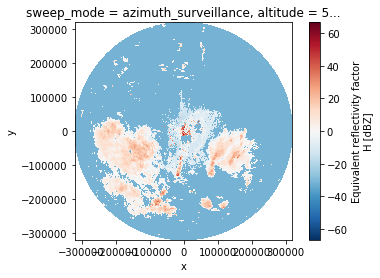

In [6]:
cf1['sweep_1'].DBZH.plot.pcolormesh(x='x', y='y')
pl.gca().set_aspect('equal')

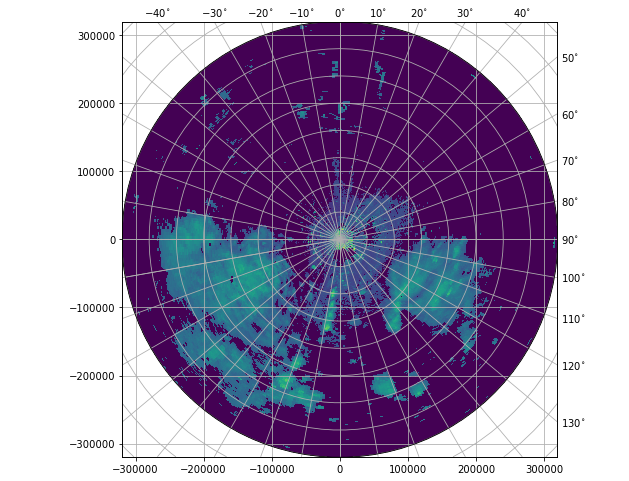

In [7]:
fig = pl.figure(figsize=(10,8))
cf1['sweep_1'].DBZH.wradlib.plot_ppi(proj='cg', fig=fig)

In [8]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(central_latitude=cf1['sweep_1'].latitude.values, 
                                      central_longitude=cf1['sweep_1'].longitude.values)

< GeoAxes: <cartopy.crs.AzimuthalEquidistant object at 0x7fbcff87fd00> >


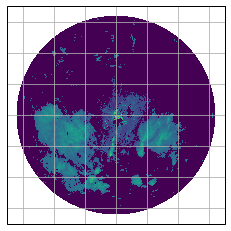

In [9]:
map_proj = ccrs.AzimuthalEquidistant(central_latitude=cf1['sweep_1'].latitude.values, 
                                      central_longitude=cf1['sweep_1'].longitude.values)
pm = cf1['sweep_1'].DBZH.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

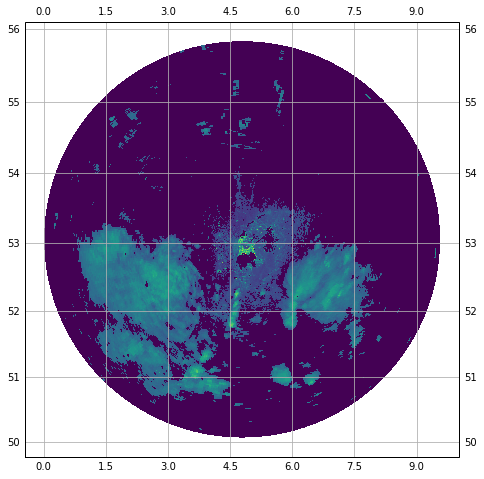

In [10]:
map_proj = ccrs.Mercator(central_longitude=cf1['sweep_1'].longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
pm = cf1['sweep_1'].DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

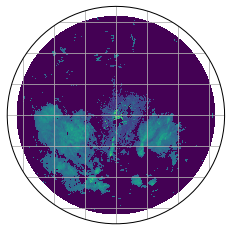

In [11]:
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

map_proj = ccrs.AzimuthalEquidistant(central_latitude=cf1['sweep_1'].latitude.values, 
                                     central_longitude=cf1['sweep_1'].longitude.values,
                                    )
pm = cf1['sweep_1'].DBZH.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
ax.set_boundary(circle, transform=ax.transAxes)


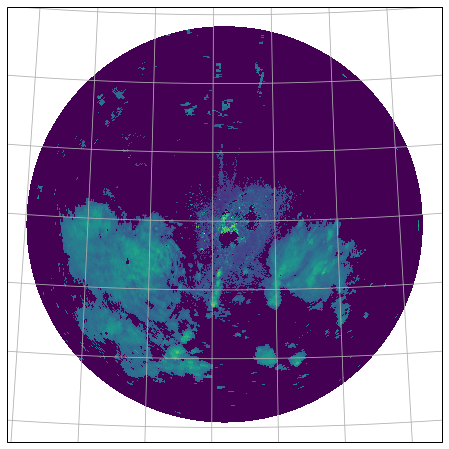

In [12]:
fig = pl.figure(figsize=(10, 8))
proj=ccrs.AzimuthalEquidistant(central_latitude=cf1['sweep_1'].latitude.values, 
                               central_longitude=cf1['sweep_1'].longitude.values)
ax = fig.add_subplot(111, projection=proj)
pm = cf1['sweep_1'].DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines()

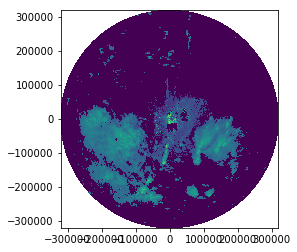

In [13]:
dbz = cf1['sweep_1']
dbz.DBZH.wradlib.plot_ppi()

### Inspect radar moments

The dataarrays can be accessed by key or by attribute. Each dataarray has the datasets dimensions and coordinates of it's parent dataset. There are attributes connected which are defined by Cf/Radial and/or ODIM_H5 standard.

In [14]:
cf1['sweep_1'].DBZH

<xarray.DataArray 'DBZH' (time: 360, range: 320)>
[115200 values with dtype=float32]
Coordinates:
    azimuth     (time) float32 ...
    elevation   (time) float32 ...
  * range       (range) float32 500.0 1500.0 2500.0 ... 318500.0 319500.0
    sweep_mode  <U20 ...
    altitude    float32 ...
    bins        (time, range) float32 ...
    gr          (time, range) float32 ...
    latitude    float32 ...
    longitude   float32 ...
    rays        (time, range) float32 ...
  * time        (time) datetime64[ns] 2011-06-10T11:40:06.694446592 ... 2011-06-10T11:40:06.638891008
    x           (time, range) float32 ...
    y           (time, range) float32 ...
    z           (time, range) float32 ...
Attributes:
    IMAGE_VERSION:  1.2
    standard_name:  radar_equivalent_reflectivity_factor_h
    long_name:      Equivalent reflectivity factor H
    units:          dBZ

In [15]:
cf1['sweep_1'].sweep_mode

<xarray.DataArray 'sweep_mode' ()>
array('azimuth_surveillance', dtype='<U20')
Coordinates:
    sweep_mode  <U20 ...
    altitude    float32 ...
    latitude    float32 ...
    longitude   float32 ...

### Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('time')` method, which sorts the radials by time.

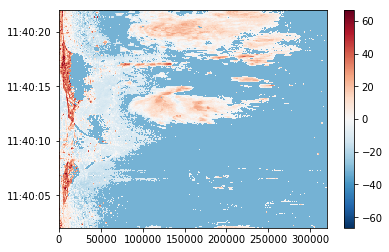

In [16]:
cf1['sweep_1'].sortby('time').DBZH.plot(add_labels=False)

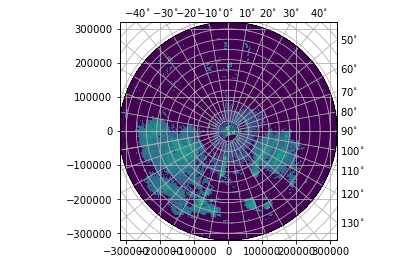

In [17]:
pm = cf1['sweep_1'].DBZH.wradlib.plot_ppi(proj={'latmin': 33e3})

In [18]:
cf1.to_odim('testodim.h5')
cf1.to_cfradial2('test_odim_as_cfradial.nc')

### Import again

In [19]:
cf1a = OdimH5('testodim.h5')
cf1b = CfRadial('test_odim_as_cfradial.nc')

In [20]:
cf1a['sweep_1']

<xarray.Dataset>
Dimensions:       (range: 320, time: 360)
Coordinates:
    azimuth       (time) float32 ...
    elevation     (time) float32 ...
  * range         (range) float32 500.0 1500.0 2500.0 ... 318500.0 319500.0
    sweep_mode    <U20 ...
    altitude      float32 ...
    bins          (time, range) float32 ...
    gr            (time, range) float32 ...
    latitude      float32 ...
    longitude     float32 ...
    rays          (time, range) float32 ...
  * time          (time) datetime64[ns] 2011-06-10T11:40:06.694446592 ... 2011-06-10T11:40:06.638891008
    x             (time, range) float32 ...
    y             (time, range) float32 ...
    z             (time, range) float32 ...
Data variables:
    DBZH          (time, range) float32 ...
    fixed_angle   float32 ...
    follow_mode   <U4 ...
    prt_mode      <U5 ...
    sweep_number  int64 ...

### Check equality

In [21]:
xr.testing.assert_equal(cf1.root, cf1a.root)
xr.testing.assert_equal(cf1['sweep_1'], cf1a['sweep_1'])
xr.testing.assert_equal(cf1.root, cf1b.root)
xr.testing.assert_equal(cf1['sweep_1'], cf1b['sweep_1'])

### Mask some values

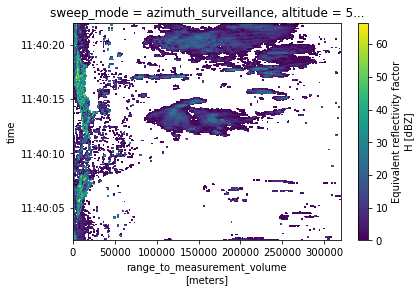

In [22]:
cf1['sweep_1']['DBZH'] = cf1['sweep_1']['DBZH'].where(cf1['sweep_1']['DBZH'] >= 0)
cf1['sweep_1']['DBZH'].sortby('time').plot()

## Load Cf/Radial1 Volume Data

In [23]:
fpath = 'netcdf/cfrad.20080604_002217_000_SPOL_v36_SUR.nc'
f = wrl.util.get_wradlib_data_file(fpath)
cf2 = CfRadial(f)

### Inspect root group

In [24]:
cf2.root

<xarray.Dataset>
Dimensions:              (sweep: 9)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int32 ...
    platform_type        |S32 ...
    primary_axis         |S32 ...
    status_xml           |S1 ...
    instrument_type      |S32 ...
    time_coverage_start  |S32 ...
    time_coverage_end    |S32 ...
    latitude             float64 ...
    longitude            float64 ...
    altitude             float64 ...
    sweep_fixed_angle    (sweep) float32 ...
    sweep_group_name     (sweep) <U7 'sweep_1' 'sweep_2' ... 'sweep_8' 'sweep_9'
Attributes:
    Conventions:         CF/Radial instrument_parameters radar_parameters rad...
    version:             1.2
    title:               TIMREX
    institution:         
    references:          
    source:              
    history:             
    comment:             
    instrument_name:     SPOLRVP8
    site_name:           
    scan_name:           
    scan_id:             0
    platform_is_mobil

### Inspect sweep group(s)

In [25]:
cf2['sweep_1']

<xarray.Dataset>
Dimensions:             (range: 996, time: 482)
Coordinates:
    sweep_mode          <U20 'azimuth_surveillance'
  * time                (time) datetime64[ns] 2008-06-04T00:15:03 ... 2008-06-04T00:15:50
  * range               (range) float32 150.0 300.0 ... 149250.0 149400.0
    azimuth             (time) float32 121.5 122.25 123.0 ... 121.5 122.25
    elevation           (time) float32 0.379 0.2362 0.1648 ... 0.5109 0.5109
    longitude           float64 120.4
    latitude            float64 22.53
    altitude            float64 45.0
    x                   (time, range) float32 127.89255 255.78506 ... 126313.266
    y                   (time, range) float32 -78.37265 -156.74529 ... -79697.73
    z                   (time, range) float32 45.0 46.0 47.0 ... 2685.0 2689.0
    gr                  (time, range) float32 149.99593 299.99182 ... 149354.5
    rays                (time, range) float32 121.5 121.5 ... 122.25 122.25
    bins                (time, range) float32

### Inspect radar moments

In [26]:
cf2['sweep_1'].DBZ

<xarray.DataArray 'DBZ' (time: 482, range: 996)>
[480072 values with dtype=float32]
Coordinates:
    sweep_mode  <U20 'azimuth_surveillance'
  * time        (time) datetime64[ns] 2008-06-04T00:15:03 ... 2008-06-04T00:15:50
  * range       (range) float32 150.0 300.0 450.00003 ... 149250.0 149400.0
    azimuth     (time) float32 121.5 122.25 123.0 123.75 ... 120.75 121.5 122.25
    elevation   (time) float32 0.379 0.2362 0.1648 ... 0.5109 0.5109 0.5109
    longitude   float64 120.4
    latitude    float64 22.53
    altitude    float64 45.0
    x           (time, range) float32 127.89255 255.78506 ... 126313.266
    y           (time, range) float32 -78.37265 -156.74529 ... -79697.73
    z           (time, range) float32 45.0 46.0 47.0 ... 2681.0 2685.0 2689.0
    gr          (time, range) float32 149.99593 299.99182 ... 149204.6 149354.5
    rays        (time, range) float32 121.5 121.5 121.5 ... 122.25 122.25 122.25
    bins        (time, range) float32 150.0 300.0 ... 149250.0 149400.

### Create simple plot

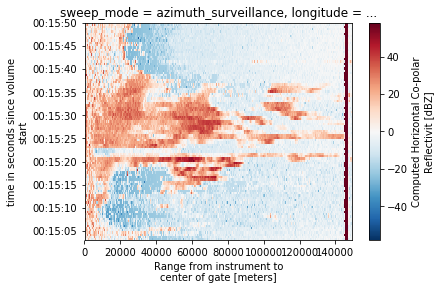

In [27]:
cf2['sweep_1'].DBZ.plot()

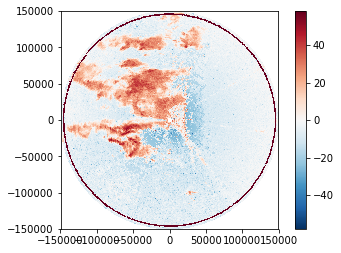

In [28]:
cf2['sweep_1'].DBZ.plot.pcolormesh(x='x', y='y', add_labels=False)
pl.gca().set_aspect('equal')

### Use wradlib DataArray connector

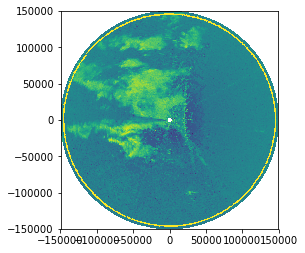

In [29]:
pm = cf2['sweep_1'].DBZ.wradlib.plot_ppi()

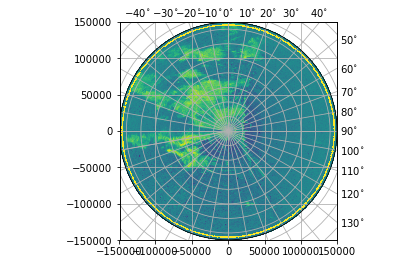

In [30]:
pm = cf2['sweep_1'].DBZ.wradlib.plot_ppi(proj='cg')

### Export data to Cf/Radial2 and ODIM_H5

In [31]:
cf2.to_cfradial2('testcfradial2.nc')
cf2.to_odim('test_cfradial_as_odim.h5')

### Import again

In [32]:
cf2a = CfRadial('testcfradial2.nc')
cf2b = OdimH5('test_cfradial_as_odim.h5')

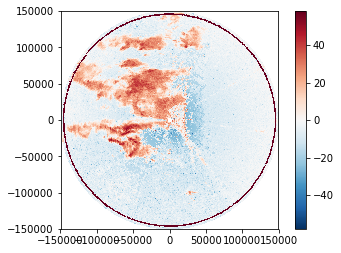

In [33]:
cf2a['sweep_1'].DBZ.plot.pcolormesh(x='x', y='y', add_labels=False)
pl.gca().set_aspect('equal')

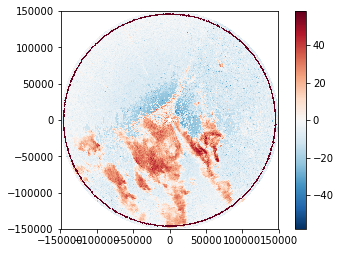

In [34]:
cf2b['sweep_1'].DBZ.plot.pcolormesh(x='x', y='y', add_labels=False)
pl.gca().set_aspect('equal')

### Check equality

For Cf/Radial there are issues with nan, which need to be fixed. For the ODIM_H5 intercomparison there are too problems with nan and issues with attributes.

In [35]:
xr.testing.assert_equal(cf2.root, cf2a.root)
xr.testing.assert_equal(cf2['sweep_1'].drop(['DBZ', 'VR']), 
                        cf2a['sweep_1'].drop(['DBZ', 'VR']))

xr.testing.assert_allclose(cf2.root.time_coverage_start, 
                           cf2b.root.time_coverage_start)